In [ ]:
!pip install datasets accelerate bitsandbytes

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from datasets import load_dataset
import random, time
import pandas as pd
from tqdm import tqdm

In [ ]:
# Load the tokenizer and model
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'

bits_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Sample dataset, doesn't really matter what it is
dataset = load_dataset("cais/mmlu", 'virology')

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def get_stats(model, tokenizer, batch_size, possible_texts):
    random_texts = random.sample(possible_texts, batch_size)

    # Prepare a sample input. Truncating a bit
    inputs = tokenizer(random_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Synchronize GPU to make sure accurate measurements
    torch.cuda.synchronize(model.device)

    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats(model.device)

    # Measure memory before the forward pass
    memory_before = torch.cuda.memory_allocated(model.device)

    # Synchronize GPU to make sure accurate measurements
    torch.cuda.synchronize(model.device)

    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats(model.device)

    # Measure memory before the forward pass
    memory_before = torch.cuda.memory_allocated(model.device)

    time_before = time.time()
    # Perform a forward pass
    with torch.no_grad():
        model(**inputs)
    time_after = time.time()

    # Synchronize again to ensure all operations are complete
    torch.cuda.synchronize(model.device)

    # Measure memory after the forward pass
    memory_after = torch.cuda.memory_allocated(model.device)

    # Calculate the difference in memory usage
    memory_used = memory_after - memory_before
    # print(f"Memory used for one forward pass: {memory_used / (1024 ** 2)} MB")

    # Also report peak memory usage
    peak_memory = torch.cuda.max_memory_allocated(model.device)
    # print(f"Peak memory usage during the forward pass: {peak_memory / (1024 ** 2)} MB")

    # print(f"Time taken for one forward pass: {time_after - time_before} seconds")

    return time_after - time_before, peak_memory / (1024 ** 2), memory_used / (1024 ** 2)


In [ ]:
# Quantized
qt_model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bits_config, device_map="auto").eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
time_spent, peak_memory, memory_used = get_stats(qt_model, tokenizer, 1, dataset['test']['question'])

time_spent, peak_memory, memory_used

(2.756621837615967, 5803.42431640625, 8.125)

In [ ]:
num_iter = 20  # Number of iterations for each batch size
results = []
batch_sizes = [1, 2, 4, 8, 16, 32]

In [ ]:
for batch_size in tqdm(batch_sizes):
    for _ in range(num_iter):
        time_spent, peak_memory, memory_used = get_stats(qt_model, tokenizer, batch_size, dataset['test']['question'])
        results.append(dict(
            batch_size=batch_size, time_spent=time_spent, peak_memory=peak_memory, memory_used=memory_used,
            model='meta-llama/Meta-Llama-3-8B-Instruct (quantized)'
            ))

100%|██████████| 6/6 [00:22<00:00,  3.79s/it]


In [ ]:
# Non Quantized
non_qt_model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto").eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
time_spent, peak_memory, memory_used = get_stats(non_qt_model, tokenizer, 1, dataset['test']['question'])

time_spent, peak_memory, memory_used

(0.7156417369842529, 35641.7919921875, 0.0)

In [ ]:
for batch_size in tqdm(batch_sizes):
    for _ in range(num_iter):
        time_spent, peak_memory, memory_used = get_stats(non_qt_model, tokenizer, batch_size, dataset['test']['question'])
        results.append(dict(
            batch_size=batch_size, time_spent=time_spent, peak_memory=peak_memory, memory_used=memory_used,
            model='meta-llama/Meta-Llama-3-8B-Instruct (non quantized)'
            ))

100%|██████████| 6/6 [07:01<00:00, 70.30s/it]


In [ ]:
results_df = pd.DataFrame(results)
results_df.groupby(['model', 'batch_size']).agg(['mean', 'median', 'min', 'max'])

time_spent  \
                                                                    mean   
model                                              batch_size              
meta-llama/Meta-Llama-3-8B-Instruct (non quanti... 1            2.710599   
                                                   2            2.723676   
                                                   4            2.791647   
                                                   8            2.975514   
                                                   16           3.659630   
                                                   32           5.873408   
meta-llama/Meta-Llama-3-8B-Instruct (quantized)    1            0.116982   
                                                   2            0.119253   
                                                   4            0.120534   
                                                   8            0.117180   
                                                   16           0.153876   
                                                   32           0.262748   

                                                                         \
                                                                 median   
model                                              batch_size             
meta-llama/Meta-Llama-3-8B-Instruct (non quanti... 1           2.700341   
                                                   2           2.703755   
                                                   4           2.766969   
                                                   8           2.903494   
                                                   16          3.794552   
                                                   32          5.505301   
meta-llama/Meta-Llama-3-8B-Instruct (quantized)    1           0.115986   
                                                   2           0.118533   
                                                   4           0.119629   
                                                   8           0.116799   
                                                   16          0.131377   
                                                   32          0.230977   

                                                                         \
                                                                    min   
model                                              batch_size             
meta-llama/Meta-Llama-3-8B-Instruct (non quanti... 1           2.678953   
                                                   2           2.687139   
                                                   4           2.704074   
                                                   8           2.797222   
                                                   16          2.916015   
                                                   32          3.410552   
meta-llama/Meta-Llama-3-8B-Instruct (quantized)    1           0.113212   
                                                   2           0.115492   
                                                   4           0.115809   
                                                   8           0.115279   
                                                   16          0.115750   
                                                   32          0.119662   

                                                                         \
                                                                    max   
model                                              batch_size             
meta-llama/Meta-Llama-3-8B-Instruct (non quanti... 1           2.827868   
                                                   2           2.975231   
                                                   4           2.960860   
                                                   8           3.299892   
                                                   16          5.608432   
                                                   32          9.1726

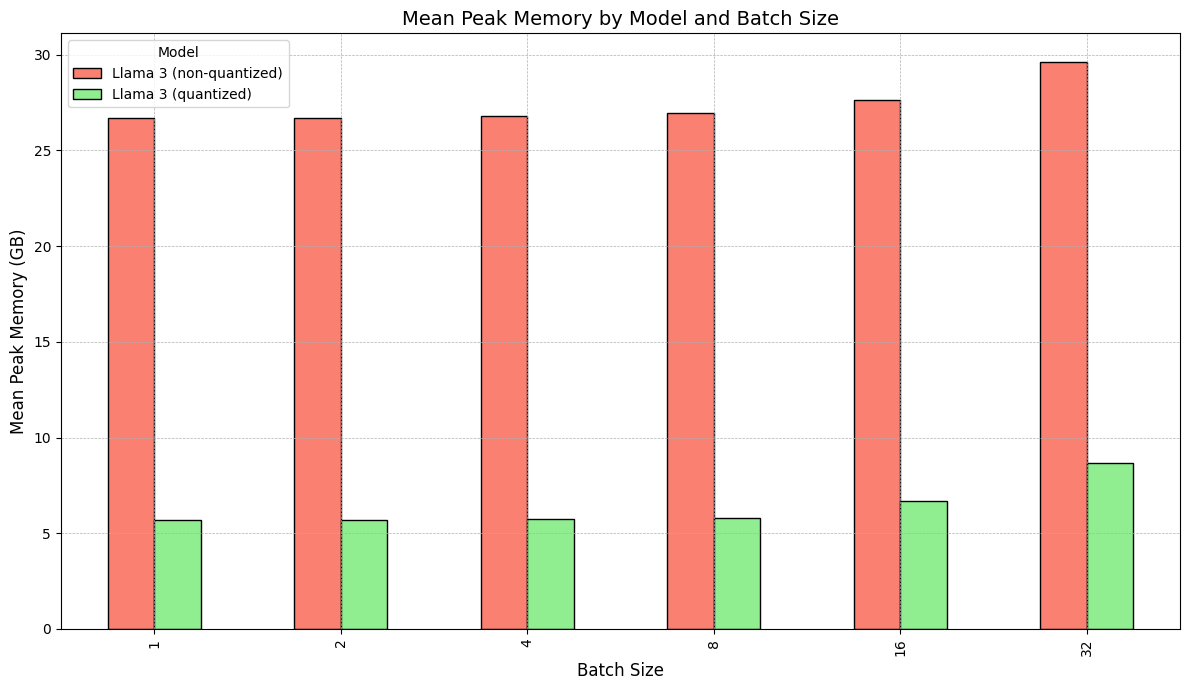

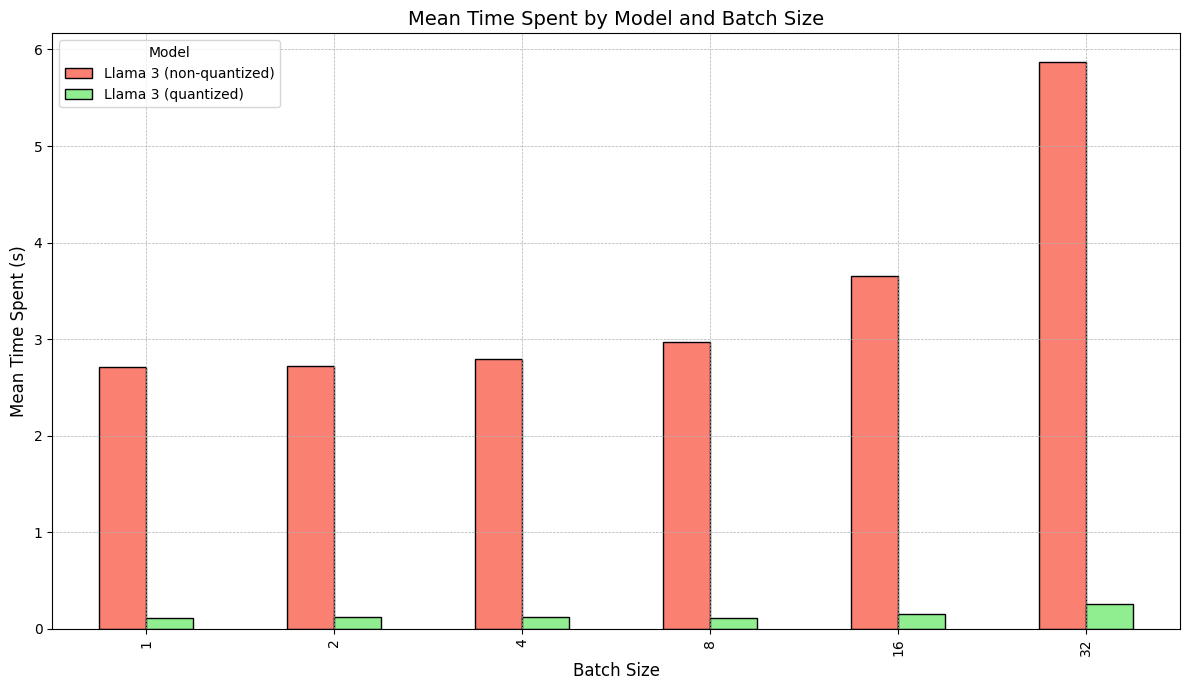

In [ ]:
import matplotlib.pyplot as plt

# Group and aggregate your data
grouped_data = results_df.groupby(['model', 'batch_size'])[['peak_memory', 'time_spent']].agg(['mean'])
grouped_data['peak_memory'] /= 1024  # Convert peak memory from KB to GB

# Unstack the model to get mean values side by side for each batch size
unstacked_data = grouped_data.unstack('model').sort_index()

# Plot for 'peak_memory'
ax = unstacked_data['peak_memory', 'mean'].plot(kind='bar', figsize=(12, 7), color=['salmon', 'lightgreen' ], edgecolor='black')
ax.set_title('Mean Peak Memory by Model and Batch Size', fontsize=14)
ax.set_xlabel('Batch Size', fontsize=12)
ax.set_ylabel('Mean Peak Memory (GB)', fontsize=12)
ax.legend(title='Model', labels=['Llama 3 (non-quantized)', 'Llama 3 (quantized)'], loc='upper left')
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot for 'time_spent'
ax = unstacked_data['time_spent', 'mean'].plot(kind='bar', figsize=(12, 7), color=['salmon', 'lightgreen'], edgecolor='black')
ax.set_title('Mean Time Spent by Model and Batch Size', fontsize=14)
ax.set_xlabel('Batch Size', fontsize=12)
ax.set_ylabel('Mean Time Spent (s)', fontsize=12)
ax.legend(title='Model', labels=['Llama 3 (non-quantized)', 'Llama 3 (quantized)'])
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# checking top tokens

In [ ]:
test_q = 'hello'

test_q_encoded = tokenizer(test_q, return_tensors="pt").to(qt_model.device)
qt_result = qt_model(**test_q_encoded)

non_qt_result = non_qt_model(**test_q_encoded)

In [ ]:
import torch.nn.functional as F

# Convert logits to probabilities
probs1 = F.softmax(non_qt_result.logits[-1][-1], dim=0)
probs2 = F.softmax(non_qt_result.logits[-1][-1], dim=0)


# Calculate the mixture of the two distributions
mixture = 0.5 * (probs1 + probs2)

# Compute KL divergence from each distribution to the mixture
kl1 = F.kl_div(mixture.log(), probs1, reduction='batchmean')
kl2 = F.kl_div(mixture.log(), probs2, reduction='batchmean')

# Calculate the Jensen-Shannon divergence
jsd = 0.5 * (kl1 + kl2)

# Optionally, take the square root to get the square root of the Jensen-Shannon divergence
jsd_sqrt = torch.sqrt(abs(jsd))

print(f"Jensen-Shannon divergence: {jsd.item()}")
print(f"Square root of Jensen-Shannon divergence: {jsd_sqrt.item()}")

Jensen-Shannon divergence: 0.0
Square root of Jensen-Shannon divergence: 0.0


In [ ]:
top_k = 10

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return intersection / union

jaccard_similarity(set(qt_result.logits[-1][-1].argsort()[-top_k:].tolist()), set(non_qt_result.logits[-1][-1].argsort()[-top_k:].tolist()))

0.8181818181818182

In [ ]:
performance_results = []

for question in tqdm(dataset.filter(lambda x: len(x['question']) < 512)['test']['question']):
    test_q_encoded = tokenizer(question, return_tensors="pt").to(qt_model.device)
    qt_result = qt_model(**test_q_encoded)
    non_qt_result = non_qt_model(**test_q_encoded)

    probs1 = F.softmax(qt_result.logits[-1][-1], dim=0)
    probs2 = F.softmax(non_qt_result.logits[-1][-1], dim=0)


    # Calculate the mixture of the two distributions
    mixture = 0.5 * (probs1 + probs2)

    # Compute KL divergence from each distribution to the mixture
    kl1 = F.kl_div(mixture.log(), probs1, reduction='batchmean')
    kl2 = F.kl_div(mixture.log(), probs2, reduction='batchmean')

    # Calculate the Jensen-Shannon divergence
    jsd = 0.5 * (kl1 + kl2)

    # Optionally, take the square root to get the square root of the Jensen-Shannon divergence
    jsd_sqrt = torch.sqrt(abs(jsd)).item()

    for top_k in [1, 3, 5, 10, 20]:
        j = jaccard_similarity(set(qt_result.logits[-1][-1].argsort()[-top_k:].tolist()), set(non_qt_result.logits[-1][-1].argsort()[-top_k:].tolist()))
        performance_results.append(dict(
            question=question, top_k=top_k, jaccard=j, jsd_sqrt=jsd_sqrt
            ))

Filter:   0%|          | 0/166 [00:00<?, ? examples/s]

Filter:   0%|          | 0/18 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5 [00:00<?, ? examples/s]

100%|██████████| 163/163 [00:31<00:00,  5.10it/s]


In [ ]:
performance_results_df = pd.DataFrame(performance_results)
performance_results_df.sample(5)

,question,top_k,jaccard,jsd_sqrt
808,Why are the viruses of this family called astr...,10,0.666667,0.000269
572,A special feature of adaptive immunity is:,5,0.666667,0.000316
159,The noroviruses typically cause which of the f...,20,0.904762,0.000346
282,How is the parvovirus family targeted to reduc...,5,1.000000,0.000348
473,What is the most important factor for virus cl...,10,1.000000,0.000264


In [ ]:
performance_results_df.groupby(['top_k'])[['jaccard', 'jsd_sqrt']].agg(['mean', 'median'])

jaccard            jsd_sqrt          
           mean    median      mean    median
top_k                                        
1      0.828221  1.000000  0.000367  0.000343
3      0.792638  1.000000  0.000367  0.000343
5      0.785933  0.666667  0.000367  0.000343
10     0.777094  0.818182  0.000367  0.000343
20     0.768535  0.739130  0.000367  0.000343

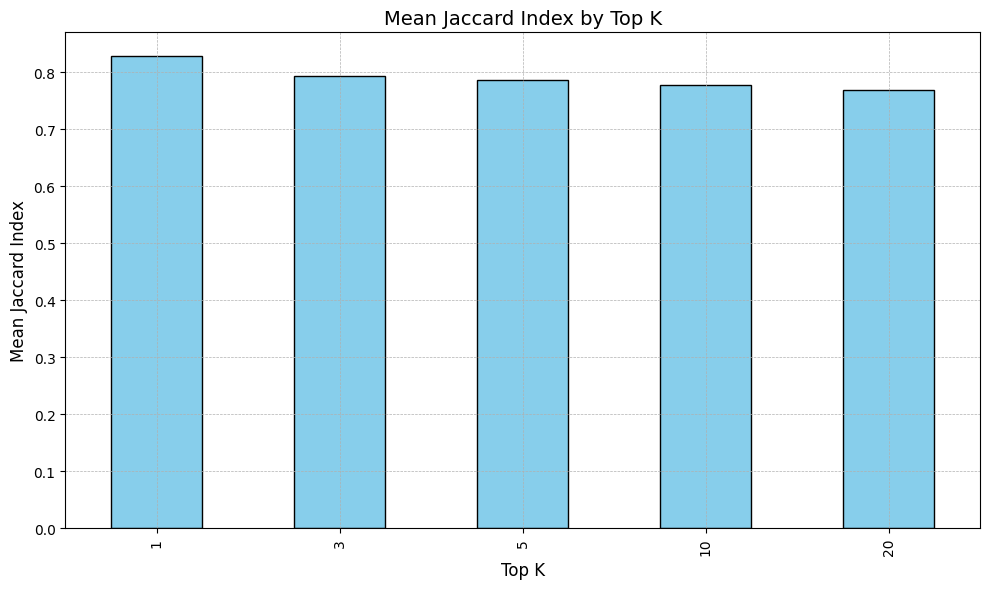

In [ ]:
import matplotlib.pyplot as plt

# Calculating the mean of 'jaccard' for each 'top_k', rounding to 5 decimal places, and plotting as a bar chart
ax = performance_results_df.groupby('top_k')['jaccard'].mean().plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')

# Setting title and labels with a larger font size for better readability
ax.set_title('Mean Jaccard Index by Top K', fontsize=14)
ax.set_xlabel('Top K', fontsize=12)
ax.set_ylabel('Mean Jaccard Index', fontsize=12)

# Adding grid lines to the plot for easier evaluation of the values
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import string
letters = string.ascii_uppercase

def parse_q(dataset_item):
    question = dataset_item['question']
    choices = dataset_item['choices']
    answer = dataset_item['answer']

    letter_choices = '\n'.join([letters[i]+': ' + choice for i, choice in enumerate(choices)]).strip()
    letter_answer = letters[answer]

    final_q = 'Recall your virology knowledge and box your final answer with [[A]] or [[B]] [[F]] or [[D]], etc\n\n'+ question + '\n\n' + letter_choices

    return final_q, letter_answer

final_q, letter_answer = parse_q(dataset['test'][0])

print(final_q)


Recall your virology knowledge and box your final answer with [[A]] or [[B]] [[F]] or [[D]], etc

How many human polyomaviruses are known at present?

A: 100
B: 1
C: 10
D: unknown


In [ ]:
import re, time

def ask_llama(dataset_item, model, tokenizer, **kwargs):
    final_q, letter_answer = parse_q(dataset_item)
    time_before = time.time()
    result = tokenizer.decode(model.generate(
        tokenizer.apply_chat_template(
            [{'role': 'human', 'content': final_q}], return_tensors='pt').to(model.device),
        pad_token_id=tokenizer.eos_token_id,
        **kwargs
    )[0]).split('<|end_header_id|>')[-1].split('<|eot_id|>')[0].strip()
    time_after = time.time()
    try:
        model_answer = re.findall(r'\[\[[A-Z]\]\]', result)[0][2]
    except:
        model_answer = None
    return model_answer == letter_answer, model_answer, letter_answer, result, time_after - time_before

In [ ]:
ask_llama(dataset['test'][0], qt_model, tokenizer, temperature=0.1)

(False,
 None,
 'A',
 'A virology question!\n\nAccording to my knowledge, there are only 2 known human polyomaviruses:\n\n* JC polyomavirus (JCV)\n* BK polyomavirus (BKV)\n\nSo, the correct answer is:\n\nB: 1',
 5.23343563079834)

In [ ]:
ask_llama(dataset['test'][0], non_qt_model, tokenizer, max_new_tokens=32, temperature=0.1)

(False,
 None,
 'A',
 'A virology question!\n\nAccording to my knowledge, there are 7 known human polyomaviruses:\n\n* JC polyomavirus (',
 23.851145029067993)

In [ ]:
benchmkark_results = []
for test_q in tqdm(dataset.filter(lambda x: len(x['question']) < 64)['test']):

    qt_correct, qt_model_answer, letter_answer, qt_result, qt_time = ask_llama(
        test_q, qt_model, tokenizer, temperature=0.1, max_new_tokens=256
        )
    non_qt_correct, non_qt_model_answer, letter_answer, non_qt_result, non_qt_time = ask_llama(
        test_q, non_qt_model, tokenizer, temperature=0.1, max_new_tokens=256
        )

    benchmkark_results.append(dict(
        question=test_q['question'],
        qt_correct=qt_correct,
        non_qt_correct=non_qt_correct,
        qt_model_answer=qt_model_answer,
        non_qt_model_answer=non_qt_model_answer,
        letter_answer=letter_answer,
        qt_time=qt_time,
        non_qt_time=non_qt_time,
        qt_result=qt_result,
        non_qt_result=non_qt_result
    ))

100%|██████████| 79/79 [1:59:47<00:00, 90.98s/it]


In [ ]:
benchmkark_results_df = pd.DataFrame(benchmkark_results)
benchmkark_results_df.sample(3)

,question,qt_correct,non_qt_correct,qt_model_answer,non_qt_model_answer,letter_answer,qt_time,non_qt_time,qt_result,non_qt_result
59,The successful anti-cancer HPV vaccine consist...,False,False,C,C,A,19.267768,70.514297,A virology question!\n\nThe correct answer is ...,The correct answer is [[C]]: Self-assemble of ...
15,Describe the morphology of a togavirus.,True,True,A,A,A,14.245740,76.546482,The correct answer is [[A]]: Enveloped spheric...,The correct answer is [[A]]: Enveloped spheric...
18,The three countries with the most drug injecto...,True,True,B,B,B,4.615298,55.797136,A virology question!\n\nAccording to the World...,"A virology question!\n\nActually, this questio..."


<Axes: >

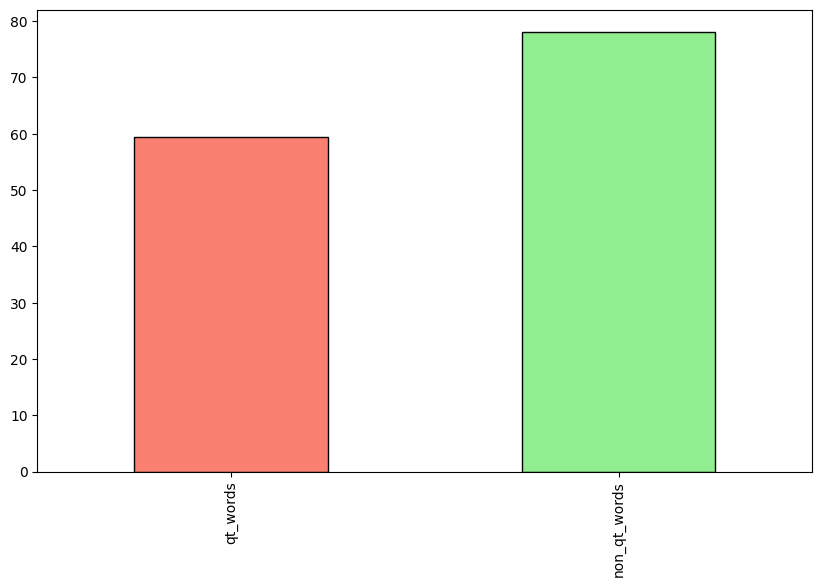

In [ ]:
benchmkark_results_df['qt_words'] = benchmkark_results_df['qt_result'].apply(lambda x: len(x.split()))
benchmkark_results_df['non_qt_words'] = benchmkark_results_df['non_qt_result'].apply(lambda x: len(x.split()))

benchmkark_results_df[['qt_words', 'non_qt_words']].mean().plot(kind='bar', figsize=(10, 6), color=['salmon', 'lightgreen'], edgecolor='black')

<Axes: >

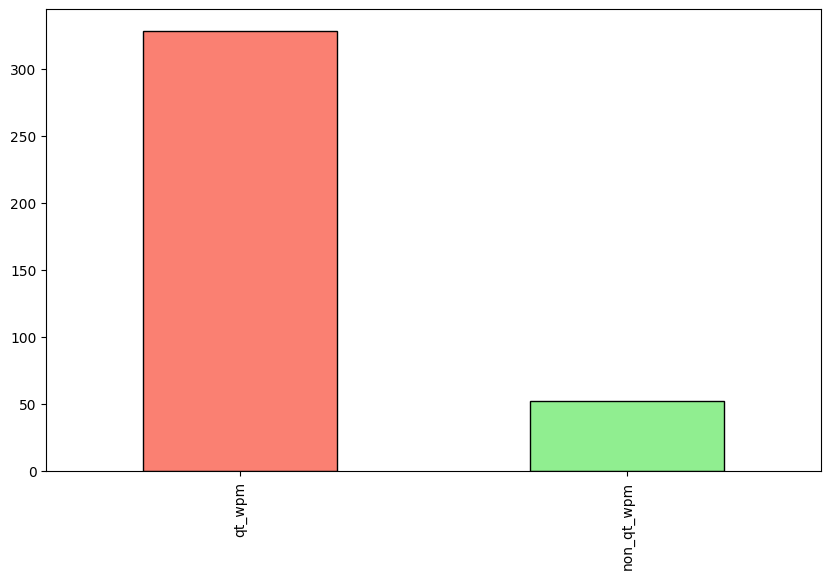

In [ ]:
benchmkark_results_df['qt_wpm'] = benchmkark_results_df['qt_words'] / (benchmkark_results_df['qt_time'] / 60)
benchmkark_results_df['non_qt_wpm'] = benchmkark_results_df['non_qt_words'] / (benchmkark_results_df['non_qt_time'] / 60)

benchmkark_results_df[['qt_wpm', 'non_qt_wpm']].mean().plot(kind='bar', figsize=(10, 6), color=['salmon', 'lightgreen'], edgecolor='black')

<Axes: >

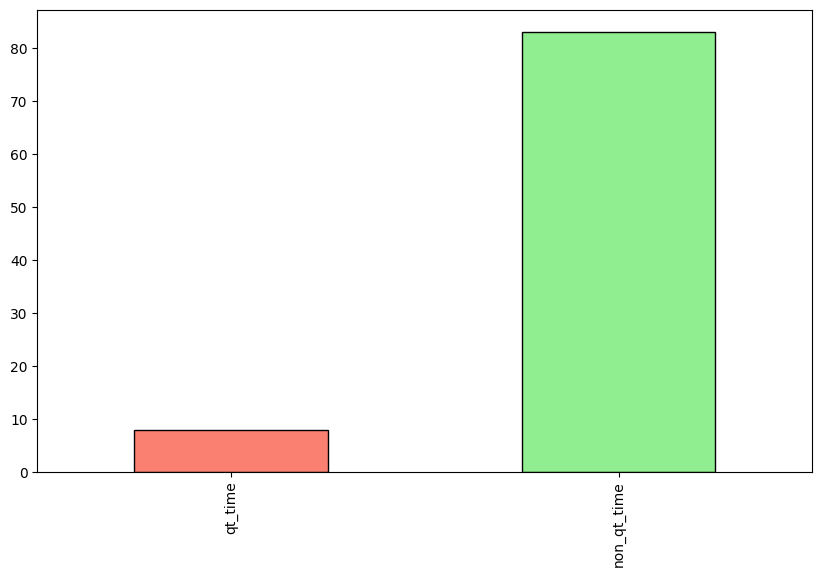

In [ ]:
benchmkark_results_df[['qt_time', 'non_qt_time']].mean().plot(kind='bar', figsize=(10, 6), color=['salmon', 'lightgreen'], edgecolor='black')

<Axes: >

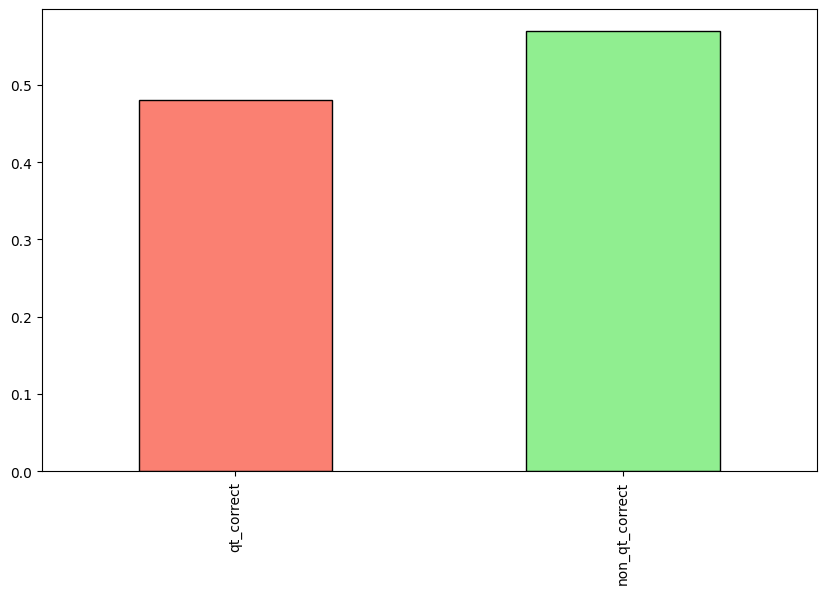

In [ ]:
benchmkark_results_df[['qt_correct', 'non_qt_correct']].mean().plot(kind='bar', figsize=(10, 6), color=['salmon', 'lightgreen'], edgecolor='black')

In [ ]:
(benchmkark_results_df['qt_model_answer'] == benchmkark_results_df['non_qt_model_answer']).value_counts(normalize=True)

True     0.759494
False    0.240506
Name: proportion, dtype: float64

In [ ]:
benchmkark_results_df[['qt_correct', 'non_qt_correct']].mean()

qt_correct        0.481013
non_qt_correct    0.569620
dtype: float64